## Instrumental Variables

We have already seen how **confounding bias** is harmful for estimating causal effects - and the good news are that we can overcome it by controlling for confounders. However, we remain helpless for scenarios where there are omitted confounders (**Omitted Variable Bias**). It is logical and straightforward: if we cannot measure nor observe a confounder, we cannot control for it, hence our estimates will be biased.

Fortunately, we can rely on **instrumental variables** for this kind of challenge. The main idea is finding another *variable that causes treatment* and that is *correlated with the outcome through the treatment*.

Let's assume that:

* $Y$ is the outcome variable;  
* $T$ is the treatment;  
* $W$ are unobserved/unmeasured confounders;  
* $Z$ is our instrumental variable.

Generally, we have the following formulation:

$Y_{i} = \beta_{0} + \kappa T_{i} + \beta \cdot W_{i} + \mu_{i} = \beta_{0} + \kappa T_{i} + \nu_{i}$

However, $Cov(T, \nu) ≠ 0$ , since we've got omitted variables.

Since $Z$ is supposed to be correlate with $Y$ only through $T$, this implies that $Cov(Z, \nu) ≠ 0$. Therefore:

$Cov(Z, Y) = Cov(Z, \beta_{0} + \kappa T + \nu) = Cov(Z, T)\kappa + Cov(Z, \nu) = Cov(Z, T)\kappa$

$\kappa = \frac{Cov(Z, Y)}{Cov(Z, T)} = \frac{Cov(Z, Y) / Var(Z)}{Cov(Z, T) / Var(Z)}$

The numerator is known as the **coefficient of the reduced form**, whereas the denominator is the **coefficient of the 1st stage**.

### The 1st Stage

Before we choose Z as an IV, we need to ensure it is a valid one. That means arguing in favor of 2 assumptions:

1) $Cov(Z, T) ≠ 0$ - IV impacts the treatment (strong 1st stage);  
2) $Y \perp Z|T$ - Exclusion restriction, stating that IV only affects outcome through the treatment.

Assumption (1) is straightforward to prove: We run a **regression of $T$ on $Z$** and check coefficient's value, statistical significance and goodness of fit. However, we cannot verify assumption (2) - we can only argue in favor of it.

### The Reduced Form (2nd Stage)

Now we build a regression of the outcome $Y$ on the instrument $Z$, in order to check how the instrument influences the outcome.

___

Basically, we estimate **ATE** by using **2-State Least Squares (2SLS)**.

1) Run 1st Stage;  
2) Run Regression of outcome on **fitted values of 1st stage**.

In the 1st stage, we are creating a new version of the treatment that is *purged from OVB*.

**IMPORTANT**: Any additional control to the 2nd stage should also be included in the 1st stage.

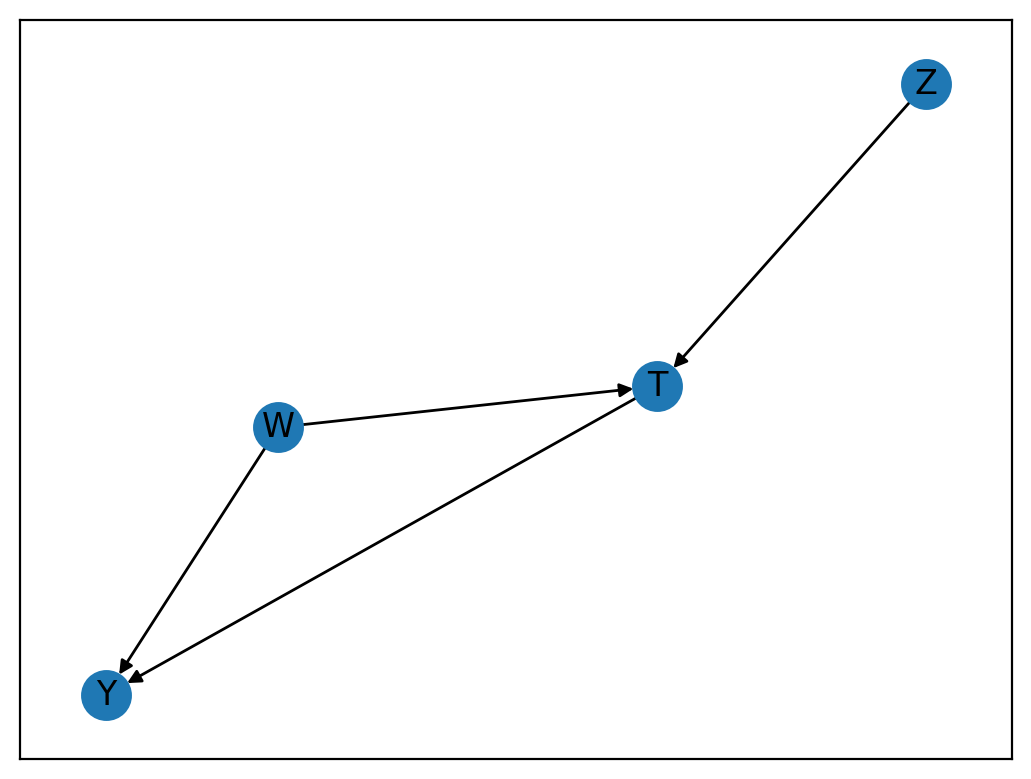

In [1]:


import networkx as nx

g = nx.DiGraph()
g.add_edge("Z", "T")
g.add_edge("T", "Y")
g.add_edge("W", "T")
g.add_edge("W", "Y")

nx.draw_networkx(g, with_labels=True)

### Libraries

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS
from causalinference import CausalModel

from matplotlib import style
import matplotlib.pyplot as plt
import seaborn as sns

style.use("fivethirtyeight")

### Data

For the sake of applying IV concepts we have just acquired, we are going to use a well-known dataset from Angrist and Krueger (1991), where they attempt to estimate the causal effect of years of schooling on the wage.

It might look tempting to just use *years of schooling*, however there are important unobserved confounders to take into account under these circumstances. Take **ability**, for instance, as it might explain not only attendance to college (hence increasing *years of schooling*) but also a higher *wage* at work. Obviously, ability is something we don't have data on, and it would be pretty difficult to have reliable data on it.

Therefore, this is the ideal scenario for instrumental variables, since we have information that is correlated with *years of schooling*, such as *quarter of birth*. Children born in the last quarter of the year will be eligible to attend school at earlier ages - the result is that they will have, on average, more years of education.

In [3]:
df = pd.read_csv("../data/angrist_and_krueger_1991.csv")
df.head()

,log_wage,years_of_schooling,year_of_birth,quarter_of_birth,state_of_birth
0,5.790019,12,30,1,45
1,5.952494,11,30,1,45
2,5.315949,12,30,1,45
3,5.595926,12,30,1,45
4,6.068915,12,30,1,37


`year_of_birth` and `quarter_of_birth` are categorical variables, even though they have numeric formats.

In [4]:
df["year_of_birth"].value_counts()

year_of_birth
39    35805
38    35223
37    33969
30    33602
35    32773
36    32676
32    32211
34    31916
33    30751
31    30583
Name: count, dtype: int64

In [5]:
df["quarter_of_birth"].value_counts()

quarter_of_birth
3    86856
1    81671
4    80844
2    80138
Name: count, dtype: int64

From the visualization below, we can see that children born in the last quarter indeed tend to have more years of schooling. So it seems quite a promising IV.

Moreover, it seems that *year of birth* highly affects *years of schooling* as well. Fortunately, we've got this variable included and can control for them.

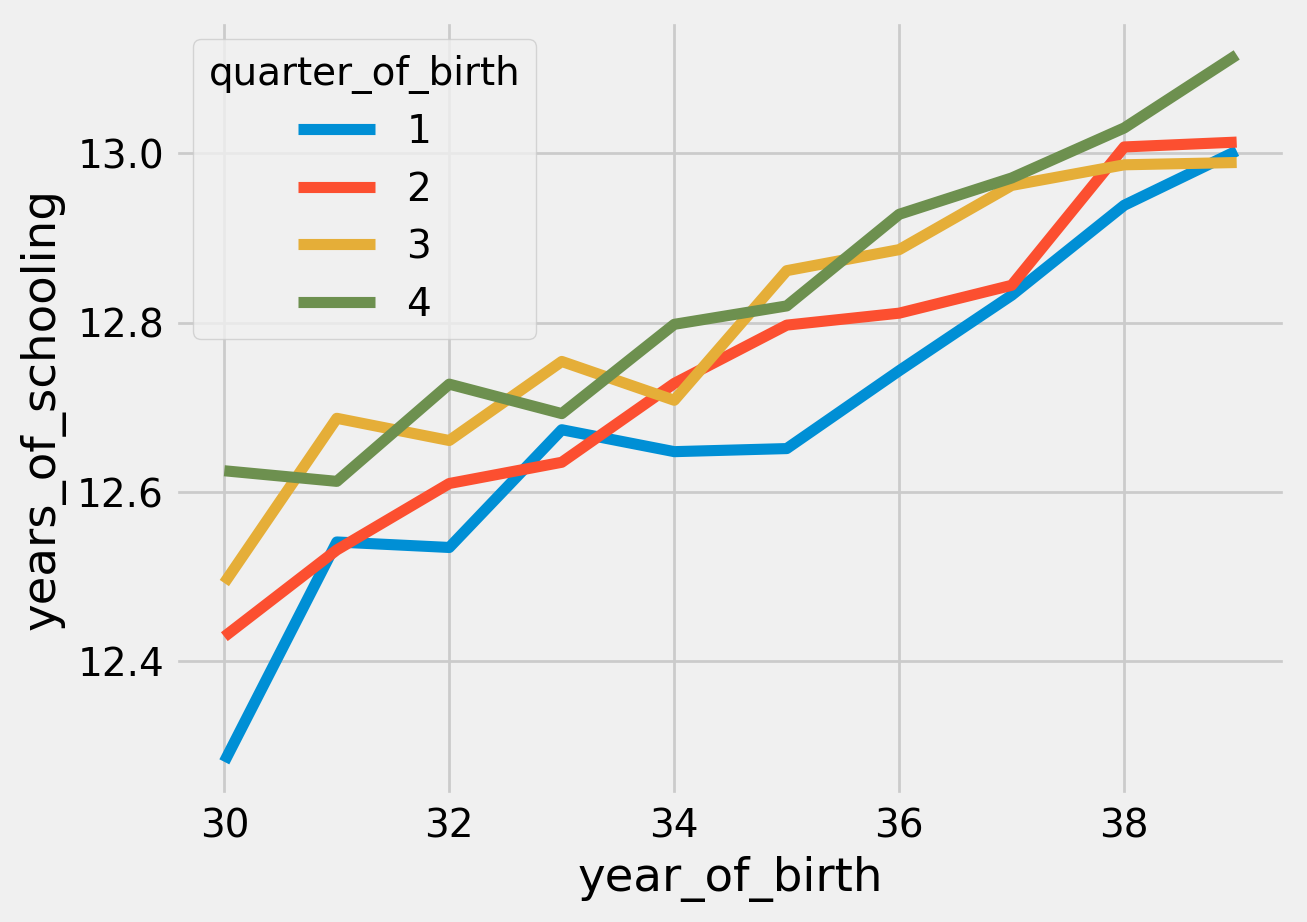

In [6]:
pd.pivot_table(
    data=df,
    index="year_of_birth",
    columns="quarter_of_birth",
    values="years_of_schooling",
    aggfunc="mean"
).plot()
plt.ylabel("years_of_schooling")
plt.show()

Some basic definitions:

In [7]:
df = df.assign(q4 = lambda x: (x["quarter_of_birth"] == 4).astype(int))
df.head()

,log_wage,years_of_schooling,year_of_birth,quarter_of_birth,state_of_birth,q4
0,5.790019,12,30,1,45,0
1,5.952494,11,30,1,45,0
2,5.315949,12,30,1,45,0
3,5.595926,12,30,1,45,0
4,6.068915,12,30,1,37,0


In [8]:
Y = "log_wage"
T = "years_of_schooling"
X1 = "year_of_birth"
X2 = "state_of_birth"
Z = "q4"

### ATE estimated without accounting for OVB

Let's pretend that we decide to ignore unobserved confounders and compute ATE.

In [9]:
biased_estimator = smf.ols(f"{Y} ~ {T}+ C({X1}) + C({X2})", data=df).fit()
biased_estimator.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,4.9509,0.009,577.737,0.000,4.934,4.968
C(year_of_birth)[T.31],-0.0052,0.005,-1.046,0.295,-0.015,0.005
C(year_of_birth)[T.32],-0.0107,0.005,-2.159,0.031,-0.020,-0.001
C(year_of_birth)[T.33],-0.0126,0.005,-2.510,0.012,-0.022,-0.003
C(year_of_birth)[T.34],-0.0161,0.005,-3.249,0.001,-0.026,-0.006
C(year_of_birth)[T.35],-0.0277,0.005,-5.620,0.000,-0.037,-0.018
C(year_of_birth)[T.36],-0.0272,0.005,-5.513,0.000,-0.037,-0.018
C(year_of_birth)[T.37],-0.0324,0.005,-6.633,0.000,-0.042,-0.023
C(year_of_birth)[T.38],-0.0331,0.005,-6.852,0.000,-0.043,-0.024
C(year_of_birth)[T.39],-0.0439,0.005,-9.109,0.000,-0.053,-0.034


Since our outcome variable is `log_wage`, we have the advantage of approximating the effect in terms of % of increase. Hence, our biased estimate is that an additional *year of schooling* increased wage by ~6.70%.

### 2-Stage Least Squares (2SLS)

Let's start with the 1st stage, in order to check whether our 1st assumption is valid.

In [10]:
first_stage = smf.ols(f"{T} ~ C({X1}) + C({X2}) + {Z}", data=df).fit()
first_stage.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.3370,0.038,295.142,0.000,11.262,11.412
C(year_of_birth)[T.31],0.1432,0.025,5.687,0.000,0.094,0.193
C(year_of_birth)[T.32],0.2110,0.025,8.490,0.000,0.162,0.260
C(year_of_birth)[T.33],0.2708,0.025,10.767,0.000,0.222,0.320
C(year_of_birth)[T.34],0.3097,0.025,12.432,0.000,0.261,0.359
C(year_of_birth)[T.35],0.3750,0.025,15.154,0.000,0.326,0.423
C(year_of_birth)[T.36],0.4202,0.025,16.968,0.000,0.372,0.469
C(year_of_birth)[T.37],0.4810,0.025,19.614,0.000,0.433,0.529
C(year_of_birth)[T.38],0.5626,0.024,23.146,0.000,0.515,0.610
C(year_of_birth)[T.39],0.6019,0.024,24.858,0.000,0.554,0.649


From the table above, we know that `q4` is statistically significant (p-value almost 0) and it increases, on average, *years of schooling*  by 0.1 years. It seems that the first assumption is met. Regarding the 2nd one, we have a strong case in favor of it, as there is no other way it could possibly affect *wage*.

Let's procede to the 2nd stage then:

In [11]:
df[f"fitted_{T}"] = first_stage.fittedvalues

second_stage = smf.ols(f"{Y} ~ C({X1}) + C({X2}) + fitted_{T}", data=df).fit()
second_stage.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,4.7466,0.305,15.548,0.000,4.148,5.345
C(year_of_birth)[T.31],-0.0078,0.007,-1.195,0.232,-0.021,0.005
C(year_of_birth)[T.32],-0.0145,0.008,-1.877,0.061,-0.030,0.001
C(year_of_birth)[T.33],-0.0174,0.009,-1.937,0.053,-0.035,0.000
C(year_of_birth)[T.34],-0.0217,0.010,-2.201,0.028,-0.041,-0.002
C(year_of_birth)[T.35],-0.0344,0.011,-3.035,0.002,-0.057,-0.012
C(year_of_birth)[T.36],-0.0347,0.012,-2.792,0.005,-0.059,-0.010
C(year_of_birth)[T.37],-0.0410,0.014,-2.947,0.003,-0.068,-0.014
C(year_of_birth)[T.38],-0.0433,0.016,-2.711,0.007,-0.075,-0.012
C(year_of_birth)[T.39],-0.0547,0.017,-3.227,0.001,-0.088,-0.021


In [12]:
ate = second_stage.params[f"fitted_{T}"]
print(f"ATE = {ate:.4f}")

ATE = 0.0853


Hence, we know that the unbiased estiamte of ATE is a little higher than the biased version: an additional *year of schooling* is expected to increase wage by roughly 8.53%.

This is a nice way to validate IV approach, but unfortunately the confidence intervals are not accurate. Luckily, we have a solution for this issue.

### Python package: `linearmodels`

Let's take a look at how we can accomplish the same task by using a thirdy party library.

In [13]:
iv2sls = IV2SLS.from_formula(
    f"{Y} ~ 1 + C({X1}) + C({X2}) + [{T} ~ {Z}]",
    df
).fit()

In [14]:
ate = iv2sls.params[T]
lower, upper = iv2sls.conf_int().loc[T].values
p_value = iv2sls.pvalues[T]

print(f"ATE = {ate:.4f}, CI: ({lower:.4f}, {upper:.4f})")
print(f"p-value = {p_value:.4f}")

ATE = 0.0853, CI: (0.0353, 0.1354)
p-value = 0.0008


We arrive at the very same value for the estimated ATE, but this time we have reliable estimates for the confidence interval. Also, the p-value is way below 0.05, so that it is considered to be statistically significant.

### Our approach

In [15]:
# from causal_inference.linear import IVEstimator

In [16]:
# m = IVEstimator(data=df, outcome=Y, treatment=T, covariates=X, heterogeneous=False)
# m.fit()

In [17]:
# m.estimate_ate(plot_result=True)